### 0. Create Stub

In [154]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [155]:
import pandas as pd

In [156]:
df = pd.read_csv('/Users/nathanieldake/development/data-science/data/currency_pairs.csv')[
    ['Unnamed: 1', 'Unnamed: 2']
].rename(
    columns={'Unnamed: 1': 'pair', 'Unnamed: 2': 'conversion'}
)

df = df.assign(
    **{'from': df.pair.str.split('/').str[0], 'to': df.pair.str.split('/').str[1]}
)

df = df[2:].drop(columns=['pair'])

currency_tuples = []
for row in df.iterrows():
    currency_tuples.append(
        (row[1]['from'], row[1]['to'], float(row[1]['conversion']))
    )

In [157]:
currency_tuples[0:5]

[('AUD', 'CAD', 0.91539),
 ('AUD', 'CHF', 0.67762),
 ('AUD', 'JPY', 81.683),
 ('AUD', 'NZD', 1.05355),
 ('AUD', 'USD', 0.73046)]

In [158]:
from collections import defaultdict

In [159]:
class WeightedGraph:
    def __init__(self, currency_conversion_pairs):
        self.nodes = self._init_nodes(currency_conversion_pairs)
        self.edges = self._init_edges(currency_conversion_pairs)
        
    def _init_nodes(self, currency_conversion_pairs):
        nodes = set()
        for cp in currency_conversion_pairs:
            nodes.add(cp[0])
            nodes.add(cp[1])
        return nodes
    
    def _init_edges(self, currency_conversion_pairs):
        edges = defaultdict(dict)
        for cp in currency_conversion_pairs:
            edges[cp[0]].update({cp[1]: cp[2]})
            edges[cp[1]].update({cp[0]: 1 / cp[2]})
            
        return edges      

In [160]:
g = WeightedGraph(currency_tuples)

In [161]:
g.edges['AUD']

{'CAD': 0.91539,
 'CHF': 0.67762,
 'JPY': 81.683,
 'NZD': 1.05355,
 'USD': 0.73046,
 'EUR': 0.6318476488948985,
 'GBP': 0.5363569562815445}

### 0.1 Plot via nx

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

In [10]:
def plot_graph_via_nx(G, layout=nx.spring_layout):
    plt.figure(figsize=(12, 9))
    pos = layout(G)
    nx.draw(
        G, 
        pos=pos, 
        with_labels=True, 
        node_color="orange",
        node_size=1500,
        font_size=12,
        arrowsize=20,
        edge_color='grey',
        width=0.5
    )


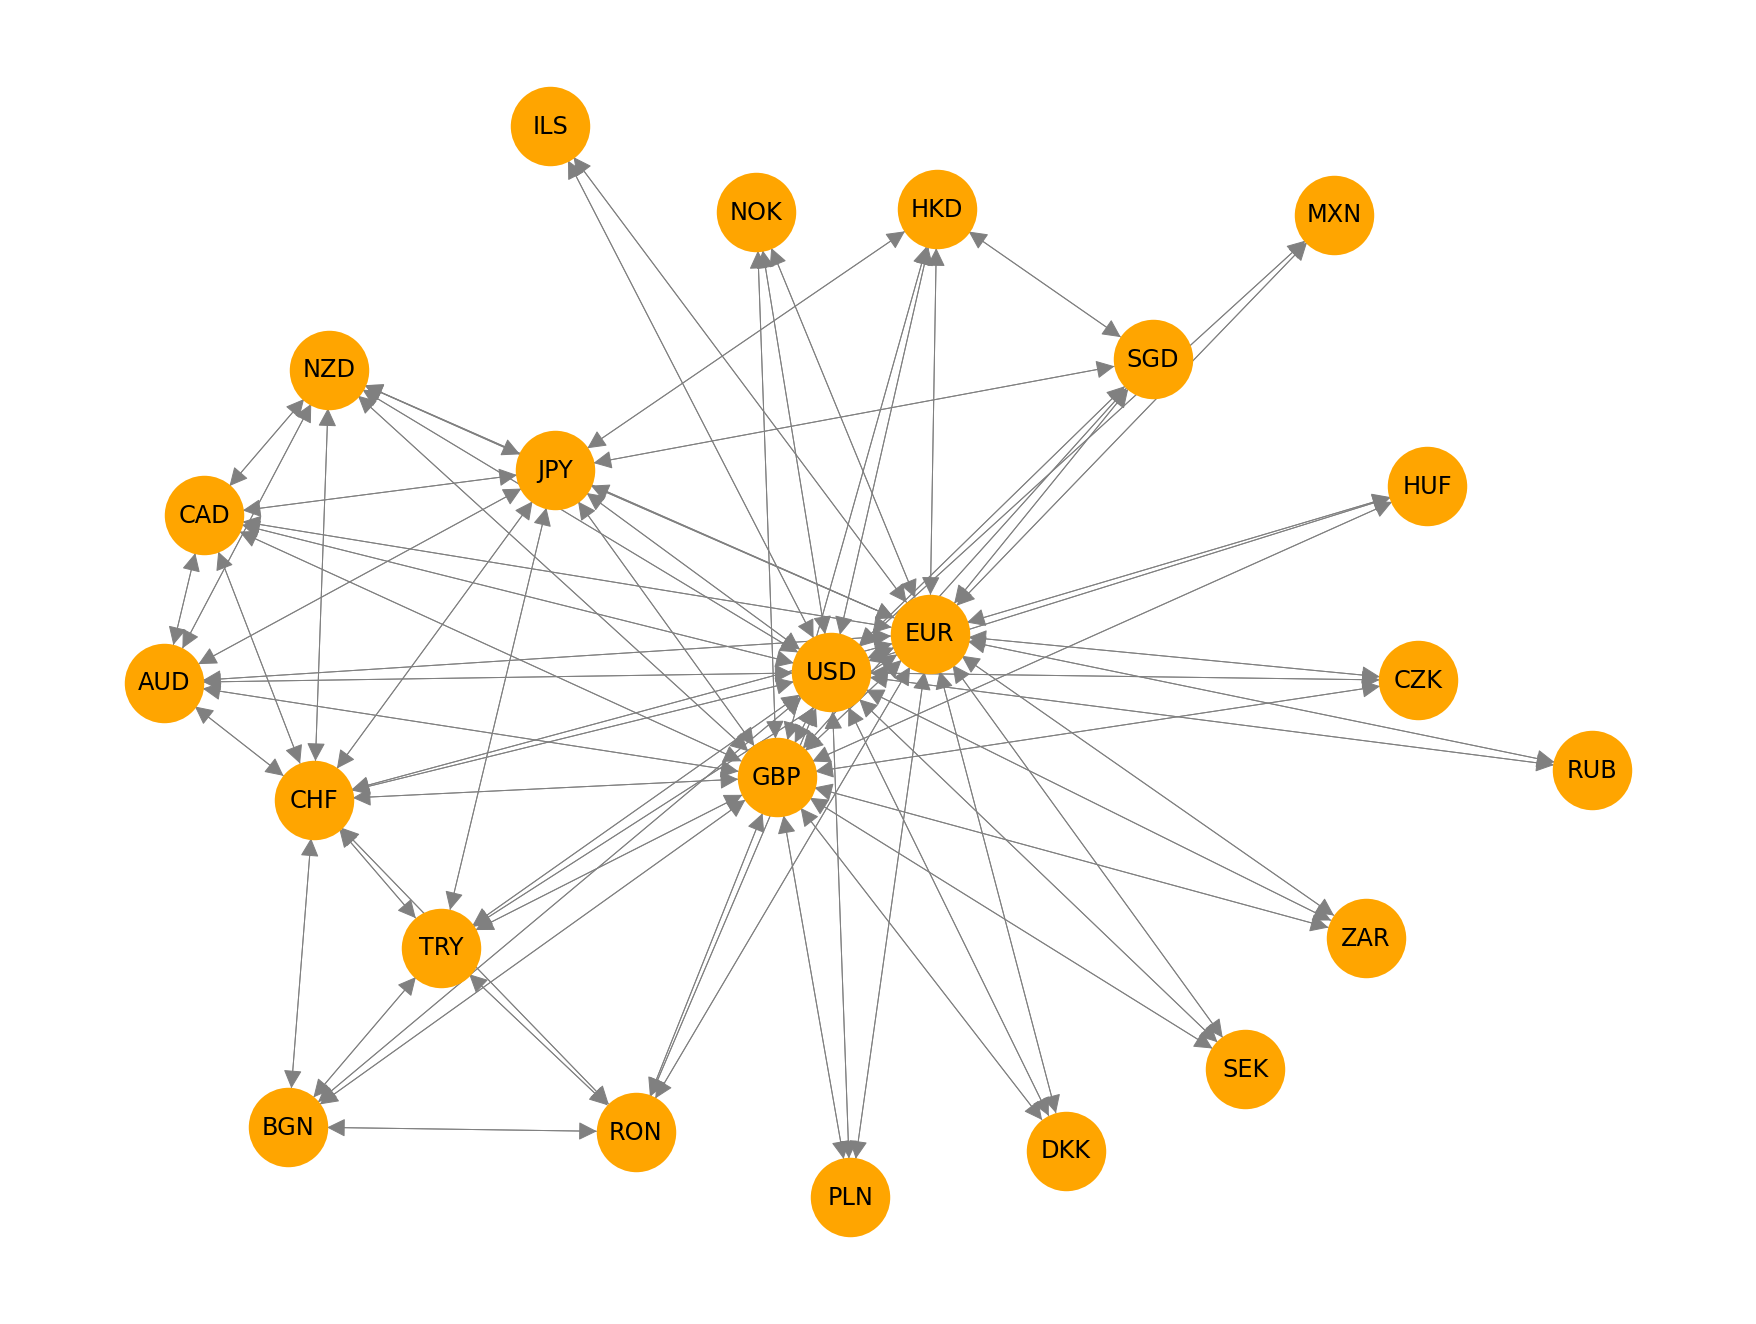

In [11]:
gnx = nx.DiGraph()
gnx.add_nodes_from(g.nodes)

full_currency_tuples = []
for start, edge in g.edges.items():
    for to, weight in edge.items():
        full_currency_tuples.append((start, to, weight))
        
gnx.add_weighted_edges_from(full_currency_tuples)

plot_graph_via_nx(gnx, layout=nx.nx_pydot.graphviz_layout)

### 1.1 DFS (base)

In [12]:
%load_ext line_profiler

In [13]:
fully_visited = set()
currently_visiting = set()

def dfs(g, node):
    """Recursive implementation"""
    if node in currently_visiting or node in fully_visited:
        return
    currently_visiting.add(node)

    for node_to in g.edges[node].keys():
        if node_to not in fully_visited:
            dfs(g, node_to)

    fully_visited.add(node)

In [14]:
%%time
dfs(g, 'AUD')

CPU times: user 39 µs, sys: 0 ns, total: 39 µs
Wall time: 42 µs


In [15]:
print(f'Number of nodes fully explored: {len(fully_visited)}')
print(f'Number of nodes not explored: {len(g.nodes - fully_visited)}')

Number of nodes fully explored: 23
Number of nodes not explored: 0


In [16]:
test = 0

In [25]:
fully_visited = set()
currently_visiting = set()


def dfs(g, node):
    """While loop implementation."""
    
    stack = [node]
    
    while len(stack) > 0:        
        node = stack.pop()

        # The fact that I check if node is in currently_visiting means I am not technically
        # doing a full, true DFS here :( See Algorithm Design Manual, pg 173
        if node in currently_visiting or node in fully_visited:
            pass
        
        currently_visiting.add(node)

        for node_to in g.edges[node].keys():
            if node_to not in fully_visited:
                stack.append(node_to)

        fully_visited.add(node)

    return

In [26]:
%%time
dfs(g, 'AUD')

CPU times: user 90 µs, sys: 1 µs, total: 91 µs
Wall time: 93 µs


In [31]:
print(f'Number of nodes fully explored: {len(fully_visited)}')
print(f'Number of nodes not explored: {len(g.nodes - fully_visited)}')

Number of nodes fully explored: 23
Number of nodes not explored: 0


In [32]:
fully_visited = set()
currently_visiting = set()

In [13]:
%lprun -T lprof0 -f dfs dfs(g, 'AUD')

UsageError: Could not find function 'dfs'.
NameError: name 'dfs' is not defined


In [15]:
from line_profiler import LineProfiler, show_text

In [16]:
lp = LineProfiler()
dfs_wrapped = lp(dfs)

NameError: name 'dfs' is not defined

In [36]:
fully_visited = set()
currently_visiting = set()

dfs_wrapped(g, 'AUD')

In [24]:
def get_total_hits(lp):
    return sum([x[1] for x in list(lp.get_stats().timings.values())[0]])

def print_report(lp):
    # lp.print_stats()
    return show_text(lp.get_stats().timings, lp.get_stats().unit)

In [47]:
print(f'Total hits: {get_total_hits(lp)}')

Total hits: 1858


In [49]:
print_report(lp)

Timer unit: 1e-06 s

Total time: 0.000669 s
File: <ipython-input-25-2fd72d7065bc>
Function: dfs at line 5

Line #      Hits         Time  Per Hit   % Time  Line Contents
     5                                           def dfs(g, node):
     6                                               # The while loop implementation requires us to keep track of the stack
     7                                               
     8         1          1.0      1.0      0.1      stack = [node]
     9                                               
    10        81         27.0      0.3      4.0      while len(stack) > 0:
    11                                                   
    12        80         38.0      0.5      5.7          node = stack.pop()
    13                                           
    14                                           
    15        80         27.0      0.3      4.0          if node in currently_visiting or node in fully_visited:
    16                                   

### 1.2 DFS (keep track of path)

In [ ]:
https://stackoverflow.com/questions/43646550/how-to-use-an-update-function-to-animate-a-networkx-graph-in-matplotlib-2-0-0

### 1.3 DFS analysis
* Really think about the big O analysis here. You know the answer is O(V + E), but why...

### 2. BFS

### 3. Compare

### 4. Improvements (any more advanced search algorithms)?
* Likely something that tries going to a central hub first
* djikstras 

### 5. Distributed Setting

### 6. Anything related to geometry you can comment on here?

## Scratch

In [17]:
from graph_search_algorithms import bfs_v1a, bfs_v1b, bfs_v1c

In [18]:
import random

### Basic BFS (Tim Roughgarden approach)

In [21]:
%%time
s = random.choice(list(g.nodes))
res = bfs_v1a(g, s)

CPU times: user 192 µs, sys: 0 ns, total: 192 µs
Wall time: 196 µs


In [22]:
print(f'Number of nodes fully explored: {len(res)}')
print(f'Number of nodes not explored: {len(g.nodes - set(res.keys()))}')

Number of nodes fully explored: 23
Number of nodes not explored: 0


In [23]:
lp = LineProfiler()
bfs_v1a_wrapped = lp(bfs_v1a)

In [25]:
res = bfs_v1a_wrapped(g, s)

In [26]:
print(f'Total hits: {get_total_hits(lp)}')

Total hits: 435


In [27]:
print_report(lp)

Timer unit: 1e-06 s

Total time: 0.000694 s
File: /Users/nathanieldake/development/data-science/intuitiveml/notebooks/computer_science/Algorithms_and_data_structures_in_python/graphs/graph_search_algorithms.py
Function: bfs_v1a at line 10

Line #      Hits         Time  Per Hit   % Time  Line Contents
    10                                           def bfs_v1a(g, s):
    11                                               """Outlined in Algorithms Illuminated (Tim Roughgarden)
    12                                               - g: graph
    13                                               - s: starting node
    14                                               """
    15         1        133.0    133.0     19.2      explored = {key: False for key in g.nodes}  
    16         1          2.0      2.0      0.3      explored[s] = True
    17                                           
    18         1         36.0     36.0      5.2      q = Queue()
    19         1         22.0     22.0    

### BFS, keeping track of paths

In [131]:
%%time
# s = random.choice(list(g.nodes))
s = 'HKD'
explored, shortest_paths = bfs_v1b(g, s)

CPU times: user 192 µs, sys: 2 µs, total: 194 µs
Wall time: 197 µs


In [132]:
print(f'Number of nodes fully explored: {len(res)}')
print(f'Number of nodes not explored: {len(g.nodes - set(res.keys()))}')

Number of nodes fully explored: 23
Number of nodes not explored: 0


In [133]:
shortest_paths['BGN']

['HKD', 'GBP', 'BGN']

In [118]:
exchange_product = []
for i in range(len(shortest_paths['BGN']) - 1):
    exchange_product.append(g.edges[shortest_paths['BGN'][i]][shortest_paths['BGN'][i + 1]])
    
reduce(mul, exchange_product)

0.21727582020907632

In [28]:
lp = LineProfiler()
bfs_v1b_wrapped = lp(bfs_v1b)

In [29]:
s = 'HKD'
explored, shortest_paths = bfs_v1b_wrapped(g, s)

In [30]:
print(f'Total hits: {get_total_hits(lp)}')

Total hits: 459


In [31]:
print_report(lp)

Timer unit: 1e-06 s

Total time: 0.000686 s
File: /Users/nathanieldake/development/data-science/intuitiveml/notebooks/computer_science/Algorithms_and_data_structures_in_python/graphs/graph_search_algorithms.py
Function: bfs_v1b at line 30

Line #      Hits         Time  Per Hit   % Time  Line Contents
    30                                           def bfs_v1b(g, s):
    31                                               """Outlined in Algorithms Illuminated (Tim Roughgarden)
    32                                               - g: graph
    33                                               - s: starting node
    34                                           
    35                                               Several new lines added in order to track the shortest paths.
    36                                               """
    37         1         12.0     12.0      1.7      explored = {key: False for key in g.nodes}
    38         1          2.0      2.0      0.3      explored[s] =

### BFS, determine shortest path and exchange rate

In [32]:
%%time
s = random.choice(list(g.nodes))
w = random.choice(list(g.nodes - {s}))
# s = 'HKD'
# w = 'BGN'
shortest_path, exchange_val = bfs_v1c(g, s, w)

CPU times: user 229 µs, sys: 6 µs, total: 235 µs
Wall time: 239 µs


In [33]:
shortest_path

['CZK', 'EUR', 'DKK']

In [34]:
exchange_val

0.29287490084071327

### BFS Skiena Approach

In [61]:
from graph_search_algorithms import bfs_v2a, bfs_v2b, bfs_v2c

In [50]:
state, parents = bfs_v2a(g, 'HKD')

In [46]:
parents['BGN']

'GBP'

In [47]:
parents['GBP']

'HKD'

In [59]:
state, parents, shortest_path = bfs_v2b(g, 'HKD', 'BGN')

In [60]:
shortest_path

['HKD', 'GBP', 'BGN']

In [62]:
state, parents, shortest_path, exchange_val = bfs_v2c(g, 'HKD', 'BGN')

In [63]:
exchange_val

0.21727582020907632

### Nate approach

In [39]:
# Get degree of every node
node_degree = defaultdict(int)
for start, edges in g.edges.items():
    for end in edges.keys():
        node_degree[start] += 1
node_degree

defaultdict(int,
            {'AUD': 7,
             'CAD': 7,
             'CHF': 10,
             'JPY': 10,
             'NZD': 7,
             'USD': 22,
             'BGN': 5,
             'RON': 6,
             'TRY': 7,
             'EUR': 21,
             'CZK': 3,
             'DKK': 3,
             'GBP': 19,
             'HKD': 5,
             'HUF': 3,
             'ILS': 2,
             'MXN': 2,
             'NOK': 3,
             'PLN': 3,
             'RUB': 2,
             'SEK': 3,
             'SGD': 5,
             'ZAR': 3})

In [53]:
from queue import Queue

def bfs_v2d(g, s, end):
    """Outlined in Algorithm Design Manual (Steve Skiena)"""

    state = {key: "undiscovered" for key in g.nodes}
    state[s] = "discovered"
    parents = {key: None for key in g.nodes}

    q = Queue()
    q.put(s)

    while not q.empty():
        v = q.get()
        for w in g.edges[v].keys():    
            if state[w] == "undiscovered":
                state[w] = "discovered"
                parents[w] = v
                q.put(w)
                if w == end:
                    break
            
        state[v] = "processed"

    shortest_path = [end]
    while True:
        shortest_path.append(parents[end])
        if parents[end] == s:
            break
        end = parents[end]

    shortest_path.reverse()

    return state, parents, shortest_path


In [54]:
state, parents, sp = bfs_v2d(g, 'HKD', 'BGN')

In [55]:
sp

['HKD', 'GBP', 'BGN']

In [56]:
lp = LineProfiler()
bfs_v2d_wrapped = lp(bfs_v2d)

In [57]:
state, parents, sp = bfs_v2d_wrapped(g, 'HKD', 'BGN')

In [60]:
sp

['HKD', 'GBP', 'BGN']

In [58]:
print(f'Total hits: {get_total_hits(lp)}')

Total hits: 479


In [59]:
print_report(lp)

Timer unit: 1e-06 s

Total time: 0.000761 s
File: <ipython-input-53-e58c1b94a828>
Function: bfs_v2d at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def bfs_v2d(g, s, end):
     4                                               """Outlined in Algorithm Design Manual (Steve Skiena)"""
     5                                           
     6         1         12.0     12.0      1.6      state = {key: "undiscovered" for key in g.nodes}
     7         1          2.0      2.0      0.3      state[s] = "discovered"
     8         1          7.0      7.0      0.9      parents = {key: None for key in g.nodes}
     9                                           
    10         1         32.0     32.0      4.2      q = Queue()
    11         1         15.0     15.0      2.0      q.put(s)
    12                                           
    13        24         61.0      2.5      8.0      while not q.empty():
    14        23   

In [75]:
for edge in g.edges:
sorted(d.items(), key=lambda x: node_degree[x[0]], reverse=True)

[('USD', 0.73046),
 ('EUR', 0.6318476488948985),
 ('GBP', 0.5363569562815445),
 ('CHF', 0.67762),
 ('JPY', 81.683),
 ('CAD', 0.91539),
 ('NZD', 1.05355)]

In [122]:
for edge_start, d in g.edges.items():
    g.edges[edge_start] = dict(sorted(d.items(), key=lambda x: node_degree[x[0]], reverse=True))

In [84]:
lp = LineProfiler()
bfs_v2d_wrapped = lp(bfs_v2d)

In [85]:
state, parents, sp = bfs_v2d_wrapped(g, 'HKD', 'BGN')

In [86]:
print(f'Total hits: {get_total_hits(lp)}')

Total hits: 487


In [87]:
print_report(lp)

Timer unit: 1e-06 s

Total time: 0.000737 s
File: <ipython-input-53-e58c1b94a828>
Function: bfs_v2d at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def bfs_v2d(g, s, end):
     4                                               """Outlined in Algorithm Design Manual (Steve Skiena)"""
     5                                           
     6         1         12.0     12.0      1.6      state = {key: "undiscovered" for key in g.nodes}
     7         1          1.0      1.0      0.1      state[s] = "discovered"
     8         1          7.0      7.0      0.9      parents = {key: None for key in g.nodes}
     9                                           
    10         1         31.0     31.0      4.2      q = Queue()
    11         1         15.0     15.0      2.0      q.put(s)
    12                                           
    13        24         52.0      2.2      7.1      while not q.empty():
    14        23   

### Nate approach with DFS

In [175]:
from graph_search_algorithms import dfs_v1a

In [176]:
from copy import deepcopy

In [186]:
gsort = deepcopy(g)
for edge_start, d in gsort.edges.items():
    gsort.edges[edge_start] = dict(sorted(d.items(), key=lambda x: node_degree[x[0]]))

In [202]:
lp = LineProfiler()
dfs_wrapped = lp(dfs_v1a)

In [203]:
%%time
dfs_wrapped(g, 'HKD', 'BGN')

EUR
GBP
JPY
SGD
USD
AUD
EUR
GBP
NZD
BGN
CPU times: user 543 µs, sys: 202 µs, total: 745 µs
Wall time: 574 µs


In [204]:
print(f'Total hits: {get_total_hits(lp)}')

Total hits: 63


In [205]:
print_report(lp)

Timer unit: 1e-06 s

Total time: 0.00051 s
File: /Users/nathanieldake/development/data-science/intuitiveml/notebooks/computer_science/Algorithms_and_data_structures_in_python/graphs/graph_search_algorithms.py
Function: dfs_v1a at line 186

Line #      Hits         Time  Per Hit   % Time  Line Contents
   186                                           def dfs_v1a(g, s, end):
   187                                               """Outlined in Algorithms Illuminated (Tim Roughgarden)
   188                                               - g: graph
   189                                               - s: starting node
   190                                               """
   191         1         12.0     12.0      2.4      explored = {key: False for key in g.nodes}  
   192         1          1.0      1.0      0.2      explored[s] = True
   193                                           
   194         1          1.0      1.0      0.2      stack = deque()
   195         1          1.0    

In [206]:
lp = LineProfiler()
dfs_wrapped = lp(dfs_v1a)

In [207]:
%%time
dfs_wrapped(gsort, 'HKD', 'BGN')

SGD
JPY
GBP
EUR
USD
ILS
MXN
RUB
CZK
DKK
HUF
NOK
PLN
SEK
ZAR
BGN
CPU times: user 1.26 ms, sys: 723 µs, total: 1.98 ms
Wall time: 1.44 ms


In [208]:
print(f'Total hits: {get_total_hits(lp)}')

Total hits: 103


In [201]:
print_report(lp)

Timer unit: 1e-06 s

Total time: 4.4e-05 s
File: /Users/nathanieldake/development/data-science/intuitiveml/notebooks/computer_science/Algorithms_and_data_structures_in_python/graphs/graph_search_algorithms.py
Function: dfs_v1a at line 186

Line #      Hits         Time  Per Hit   % Time  Line Contents
   186                                           def dfs_v1a(g, s, end):
   187                                               """Outlined in Algorithms Illuminated (Tim Roughgarden)
   188                                               - g: graph
   189                                               - s: starting node
   190                                               """
   191         1         12.0     12.0     27.3      explored = {key: False for key in g.nodes}  
   192         1          1.0      1.0      2.3      explored[s] = True
   193                                           
   194         1          1.0      1.0      2.3      stack = deque()
   195         1          1.0    

# Greedy BFS

In [251]:
from queue import PriorityQueue


max_node_degree = max(node_degree.values())


def best_first_search(g, s, target):
    """Essentially a breadth first search with a priority queue.
    
    https://en.wikipedia.org/wiki/Best-first_search"""

    state = {key: "undiscovered" for key in g.nodes}
    state[s] = "discovered"
    parents = {key: None for key in g.nodes}

    q = PriorityQueue()
    q.put((1, s))

    while not q.empty():
        v = q.get()[1]
        for w in g.edges[v].keys():
            if state[w] == "undiscovered":
                if w == target:
                    return w
                else:
                    state[w] = "discovered"
                    parents[w] = v
                    q.put((max_node_degree - node_degree[w], w))
        state[v] = "processed"

    return "failure"

In [252]:
lp = LineProfiler()
bfs_wrapped = lp(best_first_search)

In [253]:
%%time
bfs_wrapped(g, 'HKD', 'BGN')

CPU times: user 231 µs, sys: 0 ns, total: 231 µs
Wall time: 234 µs


'BGN'

In [254]:
print(f'Total hits: {get_total_hits(lp)}')

Total hits: 61


In [255]:
print_report(lp)

Timer unit: 1e-06 s

Total time: 0.000171 s
File: <ipython-input-251-ab682011ba85>
Function: bfs_v2e at line 7

Line #      Hits         Time  Per Hit   % Time  Line Contents
     7                                           def bfs_v2e(g, s, target):
     8                                               """Outlined in Algorithm Design Manual (Steve Skiena)"""
     9                                           
    10         1         12.0     12.0      7.0      state = {key: "undiscovered" for key in g.nodes}
    11         1          2.0      2.0      1.2      state[s] = "discovered"
    12         1          6.0      6.0      3.5      parents = {key: None for key in g.nodes}
    13                                           
    14         1         29.0     29.0     17.0      q = PriorityQueue()
    15         1         14.0     14.0      8.2      q.put((1, s))
    16                                           
    17         2          7.0      3.5      4.1      while not q.empty():
  

In [263]:
lp = LineProfiler()
bfs_wrapped = lp(bfs_v2e)

In [264]:
%%time
bfs_wrapped(g, 'HKD', 'BGN')

CPU times: user 226 µs, sys: 0 ns, total: 226 µs
Wall time: 230 µs


'BGN'

In [265]:
print(f'Total hits: {get_total_hits(lp)}')

Total hits: 61


In [266]:
print_report(lp)

Timer unit: 1e-06 s

Total time: 0.00016 s
File: <ipython-input-251-ab682011ba85>
Function: bfs_v2e at line 7

Line #      Hits         Time  Per Hit   % Time  Line Contents
     7                                           def bfs_v2e(g, s, target):
     8                                               """Outlined in Algorithm Design Manual (Steve Skiena)"""
     9                                           
    10         1         11.0     11.0      6.9      state = {key: "undiscovered" for key in g.nodes}
    11         1          1.0      1.0      0.6      state[s] = "discovered"
    12         1          6.0      6.0      3.8      parents = {key: None for key in g.nodes}
    13                                           
    14         1         28.0     28.0     17.5      q = PriorityQueue()
    15         1         14.0     14.0      8.8      q.put((1, s))
    16                                           
    17         2          5.0      2.5      3.1      while not q.empty():
   

In [271]:
from queue import Queue


def bfs_v2f(g, s, target):
    """Outlined in Algorithm Design Manual (Steve Skiena)"""

    state = {key: "undiscovered" for key in g.nodes}
    state[s] = "discovered"
    parents = {key: None for key in g.nodes}

    q = Queue()
    q.put(s)

    while not q.empty():
        v = q.get()
        for w in g.edges[v].keys():
            if state[w] == "undiscovered":
                if w == target:
                    return w
                else:
                    state[w] = "discovered"
                    parents[w] = v
                    q.put(w)
        state[v] = "processed"

    return "failure"

In [272]:
lp = LineProfiler()
bfs_wrapped = lp(bfs_v2f)

In [273]:
%%time
bfs_wrapped(g, 'HKD', 'BGN')

CPU times: user 485 µs, sys: 1 µs, total: 486 µs
Wall time: 489 µs


'BGN'

In [274]:
print(f'Total hits: {get_total_hits(lp)}')

Total hits: 159


In [275]:
print_report(lp)

Timer unit: 1e-06 s

Total time: 0.000328 s
File: <ipython-input-271-e0d5fa131a38>
Function: bfs_v2f at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           def bfs_v2f(g, s, target):
     5                                               """Outlined in Algorithm Design Manual (Steve Skiena)"""
     6                                           
     7         1         12.0     12.0      3.7      state = {key: "undiscovered" for key in g.nodes}
     8         1          1.0      1.0      0.3      state[s] = "discovered"
     9         1          7.0      7.0      2.1      parents = {key: None for key in g.nodes}
    10                                           
    11         1         33.0     33.0     10.1      q = Queue()
    12         1         15.0     15.0      4.6      q.put(s)
    13                                           
    14         3         11.0      3.7      3.4      while not q.empty():
    15         

In [ ]:
# Priority queue in a greedy depth first search!